['ElasticStrainXX', 'ElasticStrainYY', 'ElasticStrainZZ', 'ElasticStrainXY', 'ElasticStrainXZ', 'ElasticStrainYZ', 'EquivalentPlasticStrain', 'PreConsolidationPressure', 'PlasticVolumetricStrain', 'VolumeRatio']
['PoissonRatio', 'CriticalStateLineSlope', 'VirginConsolidationLineSlope', 'SwellingLineSlope', 'CharacteristicPreConsolidationPressure', 'InitialVolumeRatio']
initial strain: [0, 0, 0, 0.0, 0.0, 0.0]
Elastic Volumetric Strain: 0.0
Plastic Volumetric Strain: 0.0
Total Volumetric Strain: 0.0
Elastic Volumetric Strain: 0.0
Plastic Volumetric Strain: 0.0
Total Volumetric Strain: 0.0
Elastic Volumetric Strain: 0.0
Plastic Volumetric Strain: 0.0
Total Volumetric Strain: 0.0
Elastic Volumetric Strain: -1.263460157933605e-07
Plastic Volumetric Strain: 0.0
Total Volumetric Strain: -1.263460157933605e-07
Elastic Volumetric Strain: -6.443430858891563e-06
Plastic Volumetric Strain: 0.0
Total Volumetric Strain: -6.443430858891563e-06
Elastic Volumetric Strain: -1.2749737165197932e-05
Plast

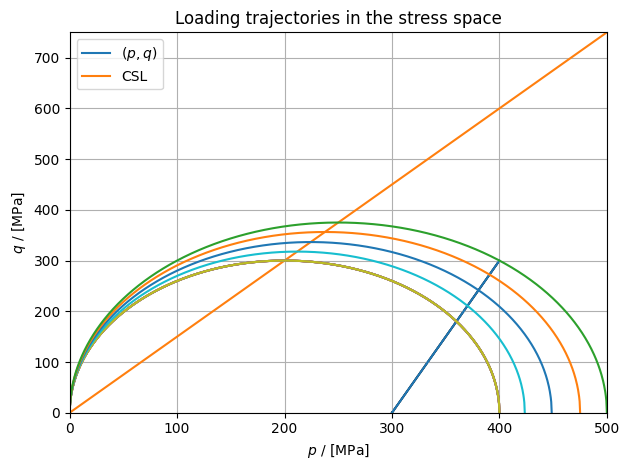

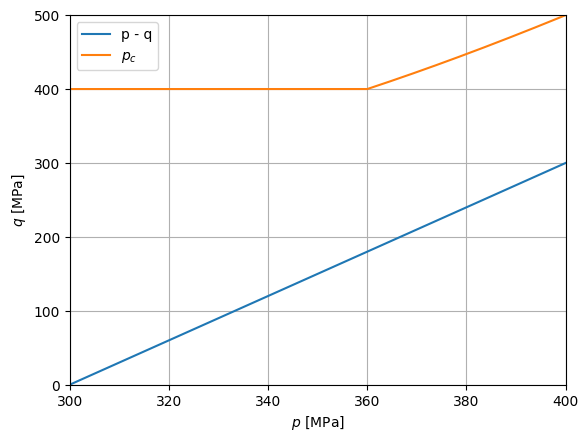

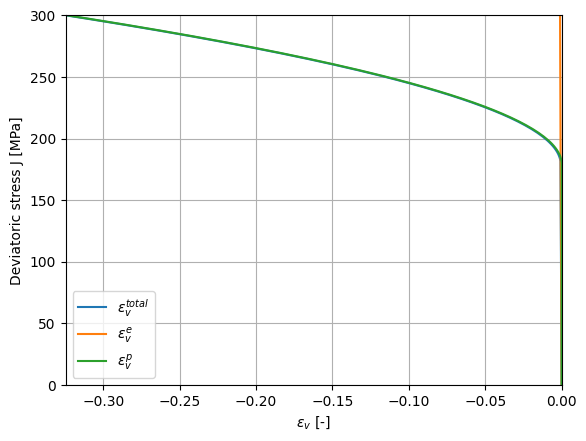

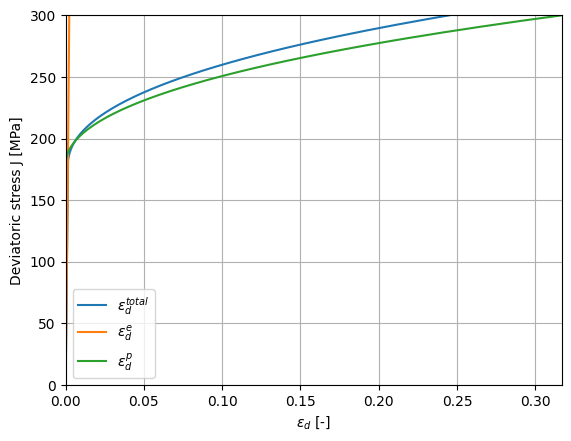

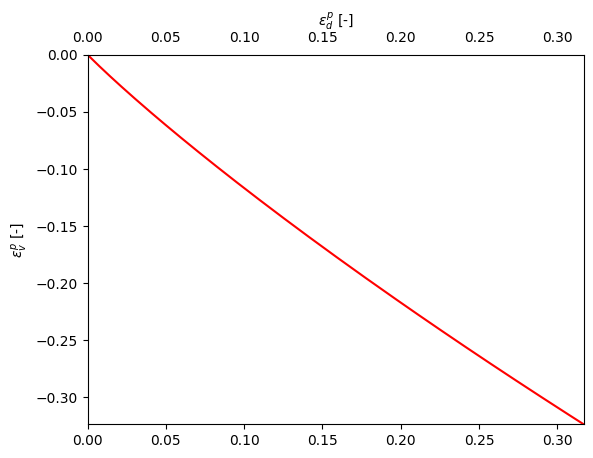

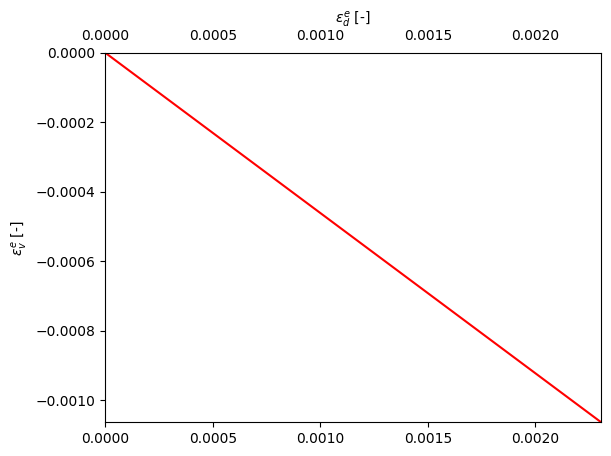

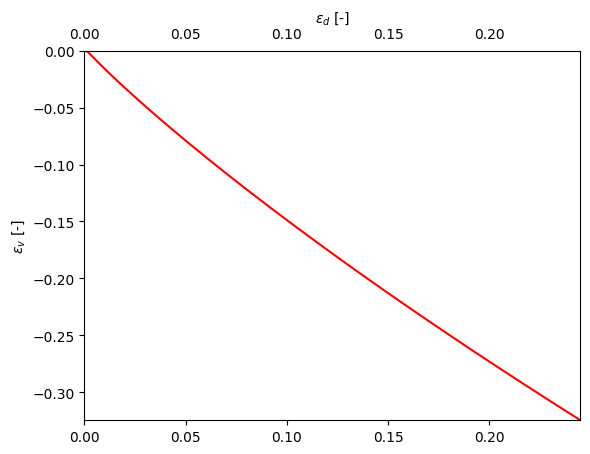

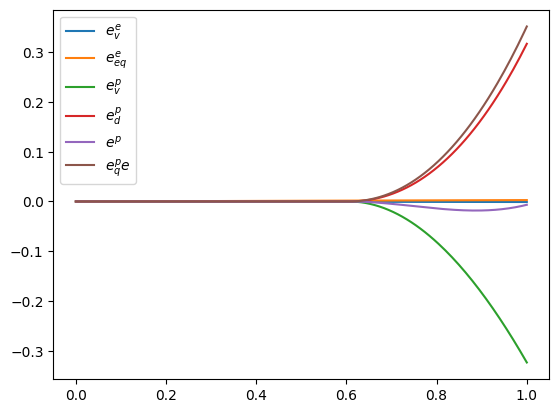

In [86]:
import os
import sys
sys.path.append("/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib/python3.11/site-packages")
import matplotlib.pyplot as plt
import numpy as np
import mtest

m = mtest.MTest()
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)
m.setMaximumNumberOfSubSteps(20)
m.setModellingHypothesis("Tridimensional")

mcc_models = [
    "ModCamClay_semiExpl",
    "ModCamClay_semiExpl_absP",
    "ModCamClay_semiExpl_constE",
]
controls = ["stress", "strain"]

# Set MCC material model implementation and path
# lib_path = "./src/libBehaviour.so"
lib_path = "/mofem_install/jupyter/thomas/mfront_interface/src/libBehaviour.so"
mcc_model = mcc_models[0]
control = controls[0]
b = mtest.Behaviour('generic', lib_path, mcc_model,'Tridimensional')
print(b.expandInternalStateVariablesNames())
print(b.getMaterialPropertiesNames())

m.setBehaviour("generic", lib_path, mcc_model)
# Material constants (according to Modified Cam clay model Report)
nu = 0.3  # Poisson ratio
la = 7.7e-2  # Slope of the virgin consolidation line
ka = 6.6e-3  # Slope of the swelling line
M = 1.5  # Slope of the critical state line (CSL)
v0 = 1.7857  # Initial volume ratio
pc0 = 400  # Initial pre-consolidation pressure in Pa
phi0 = 0.44
v0 = 1 / (1- phi0)
pamb = 0.0  # Ambient pressure in Pa

# Loading programme
tMax = 1.0  # s , total time
nTime = 200
ltime = np.linspace(0.0, tMax, nTime)

p_con =  -300 # confining pressure
p_axi = -600  # axial pressure, +12614 for reaching CSL

# Young's modulus: consistent initial value for the models
# E0 = 3 * (1 - 2 * nu) / (1 - phi0) * p_con / ka
E0 = 52
e_con = p_con * (1 - 2 * nu) / E0
e_axi = 16 * e_con

# Environment parameters
m.setExternalStateVariable("Temperature", 293.15)

# Material parameters
if mcc_model == "ModCamClay_semiExpl_constE":
    m.setMaterialProperty("YoungModulus", E0)
    m.setParameter("AmbientPressure", pamb)
    print("Young Modulus set to E =", E0 / 1e6, " MPa")
if mcc_model in (
    "ModCamClay_semiExpl",
    "ModCamClay_semiExpl_absP",
):
    m.setMaterialProperty("InitialVolumeRatio", v0)
m.setMaterialProperty("PoissonRatio", nu)
m.setMaterialProperty("CriticalStateLineSlope", M)
m.setMaterialProperty("SwellingLineSlope", ka)
m.setMaterialProperty("VirginConsolidationLineSlope", la)
m.setMaterialProperty("CharacteristicPreConsolidationPressure", pc0)

# Initial values
m.setInternalStateVariableInitialValue("PreConsolidationPressure", pc0)
m.setInternalStateVariableInitialValue("PlasticVolumetricStrain", 0)
m.setInternalStateVariableInitialValue("VolumeRatio", v0)

# Set initial stress and strain state
# eps_init = [e_con, e_con, e_con, 0.0, 0.0, 0.0]
eps_init = [0, 0, 0, 0.0, 0.0, 0.0]
print(f"initial strain: {eps_init}")
sig_init = [p_con, p_con, p_con, 0.0, 0.0, 0.0]
m.setStress(sig_init)
m.setStrain(eps_init)

m.setImposedStress("SXX", {0: p_con, 0.02: p_con, 1.0: p_con})
m.setImposedStress("SYY", {0: p_con, 0.02: p_con, 1.0: p_con})

if control == "stress":
    # stress-controlled: works only until reaching the CSL
    m.setImposedStress("SZZ", {0: p_con, 0.02: p_con, 1.0: p_axi})
if control == "strain":
    raise NotImplementedError("Not implemented")
    # Strain-controlled: works, CSL reached asymptotically for EZZ->inf
    # m.setImposedStrain("EZZ", {0: -e_con, 0.02: -e_con, 1.0: -e_axi})
    # print("confining strain in z direction: ", e_con)

s = mtest.MTestCurrentState()
wk = mtest.MTestWorkSpace()
m.completeInitialisation()
m.initializeCurrentState(s)
m.initializeWorkSpace(wk)

# initialize output lists
pCurve = np.array([p_con])
qCurve = np.array([0.0])
JCurve = np.array([0.0])
pcCurve = np.array([pc0])

eevCurve = np.array([0.0])
eedCurve = np.array([0.0])
eeeqCurve = np.array([0.0])

epvCurve = np.array([0.0])
epdCurve = np.array([0.0])
epCurve = np.array([0.0])
epeqCurve = np.array([0.0])

evCurve = np.array([0.0])
edCurve = np.array([0.0])


eQCurve = np.array([0.0])
phiCurve = np.array([phi0])
strains = np.empty(shape=(4, nTime))
stresses = np.empty(shape=(4, nTime))

# stresses[0][:] = sig_init
for k in range(4):
    strains[k][0] = eps_init[k]

for k in range(4):
    stresses[k][0] = sig_init[k]

# initialize yield functions
nPoints = 1000
pRange = np.empty(shape=(nTime, nPoints))
qFunct = np.empty(shape=(nTime, nPoints))
e_p_v = 0
# run sim
for i in range(nTime - 1):
    # Execute and print information
    m.execute(s, wk, ltime[i], ltime[i + 1])
    print("===========")
    # print(f"{s.e1}")

    p_c = s.iv1[7]
    pc = s.getInternalStateVariableValue("PreConsolidationPressure")
    # print(p_c)
    # print(pc)
    # Output variables
    p = (s.s1[0] + s.s1[1] + s.s1[2]) / 3
    q = np.sqrt(
        0.5 * (
            (s.s1[0] - s.s1[1]) ** 2 +
            (s.s1[1] - s.s1[2]) ** 2 +
            (s.s1[2] - s.s1[0]) ** 2 +
            3 * s.s1[3] ** 2
        )
    )

    # Deviatoric stress components
    s1_dev = s.s1[0] - p
    s2_dev = s.s1[1] - p
    s3_dev = s.s1[2] - p

    # Second invariant of deviatoric stress (J2)
    J2 = (1 / 6) * (
        (s1_dev - s2_dev) ** 2 +
        (s2_dev - s3_dev) ** 2 +
        (s3_dev - s1_dev) ** 2
    ) + (s.s1[3] ** 2 + s.s1[4] ** 2 + s.s1[5] ** 2) / 3

    # Deviatoric stress (J)
    J = np.sqrt(3 * J2)
    # =======================================
    # elastic
    # =======================================
    e_l = s.getInternalStateVariableValue("ElasticStrain")

    # Extract elastic strain components
    e_e_xx = e_l[0]
    e_e_yy = e_l[1]
    e_e_zz = e_l[2]
    e_e_xy = e_l[3]
    e_e_yz = e_l[4]
    e_e_xz = e_l[5]

    e_e_v = e_e_xx + e_e_yy + e_e_zz

    # Calculate deviatoric components
    e_e_xx_dev = e_e_xx - e_e_v / 3
    e_e_yy_dev = e_e_yy - e_e_v / 3
    e_e_zz_dev = e_e_zz - e_e_v / 3

    # Calculate equivalent deviatoric (von Mises) elastic strain
    e_e_d = np.sqrt(
        (2 / 3) * (
            e_e_xx_dev ** 2 + e_e_yy_dev ** 2 + e_e_zz_dev ** 2 +
            2 * (e_e_xy ** 2 + e_e_yz ** 2 + e_e_xz ** 2)
        )
    )

    # Calculate equivalent (von Mises) elastic strain
    e_e_eq = np.sqrt(
        (2 / 3) * (
            e_e_xx ** 2 + e_e_yy ** 2 + e_e_zz ** 2 -
            e_e_xx * e_e_yy -
            e_e_yy * e_e_zz -
            e_e_zz * e_e_xx +
            3 * (e_e_xy ** 2 + e_e_yz ** 2 + e_e_xz ** 2)
        )
    )

    # =======================================
    # plastic
    # =======================================
    de_p_v = s.getInternalStateVariableValue("PlasticVolumetricStrain")
    e_p_v = e_p_v + de_p_v
    e_p_eq = s.getInternalStateVariableValue("EquivalentPlasticStrain")
    e_p_d = np.sqrt(e_p_eq ** 2 - (2 / 9) * e_p_v ** 2)
    e_p = e_p_v + e_p_d
    porosity = 1 - 1 / s.getInternalStateVariableValue("VolumeRatio")
    

    # ======================================= 
    # total
    # =======================================
    # Total Volumetric strain
    e_v = s.e1[0] + s.e1[1] + s.e1[2]

    # Calculate deviatoric components
    e_xx_dev = s.e1[0] - e_v / 3
    e_yy_dev = s.e1[1] - e_v / 3
    e_zz_dev = s.e1[2] - e_v / 3

    # Calculate equivalent deviatoric (von Mises) elastic strain
    e_d = np.sqrt(
        (2 / 3) * (
            e_xx_dev ** 2 + e_yy_dev ** 2 + e_zz_dev ** 2 +
            2 * (s.e1[3] ** 2 + s.e1[4] ** 2 + s.e1[5] ** 2)
        )
    )


    # Argument for equivalent strain calculation
    argument = (
        2 / 3 * (
            s.e1[0] ** 2 +
            s.e1[1] ** 2 +
            s.e1[2] ** 2 -
            e_v ** 2 / 3 +
            2 * s.e1[3] ** 2
        )
    )
    
    
    # Total equivalent strain
    e_eq = np.sqrt(max(argument, 0))

    # Print results
    # print(f"Elastic tensor: {e_l}")
    print(f"Elastic Volumetric Strain: {e_e_v}")
    # print(f"Equivalent Elastic Strain (vM): {e_e_eq}")
    print(f"Plastic Volumetric Strain: {e_p_v}")
    # print(f"Plastic Deviatoric Strain (not sure about this): {e_p_d}")
    # print(f"Total Plastic Strain: {e_p}")
    # print(f"Equivalent Plastic Strain: {e_p_eq}")
    print(f"Total Volumetric Strain: {e_v}")
    # print(f"Equivalent Strain: {e_eq}")


    pCurve = np.append(pCurve, p)
    qCurve = np.append(qCurve, q)
    JCurve = np.append(JCurve, J)
    pcCurve = np.append(pcCurve, pc)
    phiCurve = np.append(phiCurve, porosity)
    
    eevCurve = np.append(eevCurve, e_e_v)
    eedCurve = np.append(eedCurve, e_e_d)
    eeeqCurve = np.append(eeeqCurve, e_e_eq)
    
    epvCurve = np.append(epvCurve, e_p_v)
    epdCurve = np.append(epdCurve, e_p_d)
    epCurve = np.append(epCurve, e_p)
    epeqCurve = np.append(epeqCurve, e_p_eq)
    
    evCurve = np.append(evCurve, e_v)
    edCurve = np.append(edCurve, e_d)

    for k in range(4):
        strains[k][i + 1] = s.e1[k]

    for k in range(4):
        stresses[k][i + 1] = s.s1[k]

    # calculate the yield surfaces in the p-q-space
    pRange[i] = np.linspace(0, pc, nPoints)
    qFunct[i] = M * np.sqrt(pRange[i] * (pc - pRange[i]))

# calculate the theoretical CSL
pRangeCSL = np.linspace(0, pc0 / 2, nPoints)
pRangeCSL = pRange[nTime - 2]
qFunctCSL = M * pRangeCSL

# # calculate the analytical reference solution according to Peric (2006)
# a = 3 * (1 - 2 * nu) / (2 * (1 + nu))
# k = vMstress / (pressure - pc0)
# c = (la - ka) / M
# nP = 30
# qRangeAna = np.linspace(0.0, vMstress, nP)
# pRangeAna = np.linspace(pc0, pressure, nP)
# x = qRangeAna / (M * pRangeAna)
# y = 1 - qRangeAna / (k * pRangeAna)  # = (pc0/pRangeAna)

# v0xEpsQp = np.log(
#     np.power((1 - x), c * k / (M - k)) * np.power((1 + x), c * k / (M + k))
# ) - 2 * c * np.arctan(x)
# v0xEpsQe = np.log(np.power(y, 2 * c / (k / M - M / k) - ka * k / (3 * a)))
# v0xEpsQ = v0xEpsQe + v0xEpsQp

# print some final values
print("===========")

print(f"Triaxial test: Tridimensional")
print("final normal strain in z direction: ", s.e1[1])
print("final normal stress in z direction: ", s.s1[1], "MPa")
print("final von Mises stress: ", q, "MPa")
print("final hydrostatic pressure: ", p, "MPa")
print("final pre-consolidation pressure: ", pc, "MPa")

result_dir = f"/mofem_install/jupyter/thomas/mfront_interface/results/MCC_sig_1_{p_axi}MPa/"
os.makedirs(result_dir,exist_ok=True)

# plots
# fig, ax = plt.subplots()
# ax.set_title("Numerical solution versus analytical solution (Peric, 2006)")
# ax.plot(eQCurve, qCurve / 1e3, "+", markersize=14, markevery=4, label="numerical")
# ax.plot(v0xEpsQ / v0, qRangeAna / 1e3, linewidth=2, label="analytical")
# ax.set_xlabel(r"$\epsilon_{q}$")
# ax.set_ylabel("q / kPa")
# ax.grid()
# ax.legend()
# fig.savefig(f"{result_dir}/Triaxial_NumVsAnal.pdf")

fig, ax = plt.subplots()
ax.margins(x=0, y=0)
ax.set_title("Loading trajectories in the stress space")
ax.plot(-pCurve, qCurve, label="$(p,q)$")
plt.quiver(
    -pCurve[:-1],
    qCurve[:-1],
    -pCurve[1:] - -pCurve[:-1],
    qCurve[1:] - qCurve[:-1],
    scale_units="xy",
    angles="xy",
    scale=1,
)
ax.plot(pRangeCSL, qFunctCSL, label="CSL")
for k in range(0, nTime - 1, 20):
    ax.plot(pRange[k], qFunct[k])
ax.plot(pRange[nTime - 2], qFunct[nTime - 2])
ax.set_xlabel("$p$ / [MPa]")
ax.set_ylabel("$q$ / [MPa]")
ax.grid()
ax.legend()
fig.tight_layout()
fig.show()
fig.savefig(f"{result_dir}/Triaxial_YieldSurface.pdf")

fig, ax = plt.subplots()
ax.margins(x=0, y=0)
ax.plot(-pCurve, qCurve, label="p - q")
ax.plot(-pCurve, pcCurve, label="$p_c$")
ax.set_xlabel("$p$ [MPa]")
ax.set_ylabel("$q$ [MPa]")
ax.grid()
ax.legend()
fig.show()
fig.savefig(f"{result_dir}/p_q.pdf")

fig, ax = plt.subplots()
ax.margins(x=0, y=0)
ax.plot(evCurve, JCurve, label=r"$\epsilon^{total}_{v}$")
ax.plot(eevCurve , JCurve, label=r"$\epsilon^e_{v}$")
ax.plot(epvCurve, JCurve, label=r"$\epsilon^p_{v}$")
ax.set_xlabel(r"$\epsilon_v$ [-]")
ax.set_ylabel(r"Deviatoric stress J [MPa]")
ax.grid()
ax.legend()
fig.show()
fig.savefig(f"{result_dir}/J_ep.pdf")

fig, ax = plt.subplots()
ax.margins(x=0, y=0)
ax.plot(edCurve, JCurve, label=r"$\epsilon^{total}_{d}$")
ax.plot(eedCurve , JCurve, label=r"$\epsilon^e_{d}$")
ax.plot(epdCurve, JCurve, label=r"$\epsilon^p_{d}$")
ax.set_xlabel(r"$\epsilon_d$ [-]")
ax.set_ylabel(r"Deviatoric stress J [MPa]")
ax.grid()
ax.legend()
fig.show()
fig.savefig(f"{result_dir}/J_ep.pdf")

fig, ax = plt.subplots()
ax.margins(x=0, y=0)
# ax.invert_yaxis()
ax.set_xlabel(r"$\epsilon^p_{d}$ [-]")
ax.set_ylabel(r"$\epsilon^p_{v}$ [-]")
ax.tick_params(axis='x', labeltop=True)
ax.xaxis.set_label_position('top')
ax.plot(epdCurve, epvCurve, color="red")

fig.show()
fig, ax = plt.subplots()
ax.margins(x=0, y=0)
# ax.invert_yaxis()
ax.set_xlabel(r"$\epsilon^e_{d}$ [-]")
ax.set_ylabel(r"$\epsilon^e_{v}$ [-]")
ax.tick_params(axis='x', labeltop=True)
ax.xaxis.set_label_position('top')
ax.plot(eedCurve, eevCurve, color="red")
fig.show()

fig.show()
fig, ax = plt.subplots()
ax.margins(x=0, y=0)
# ax.invert_yaxis()
ax.set_xlabel(r"$\epsilon_{d}$ [-]")
ax.set_ylabel(r"$\epsilon_{v}$ [-]")
ax.tick_params(axis='x', labeltop=True)
ax.xaxis.set_label_position('top')
ax.plot(edCurve, evCurve, color="red")
fig.show()
# ax.plot(ltime, strains[2][:], "--", color="green", label=r"$\epsilon_{\phi\phi}$")
# ax.plot(ltime, strains[1][:], label=r"$\epsilon_{zz}$")
# ax.plot(ltime, strains[3][:], color="black", label=r"$\epsilon_{rz}$")
# ax.set_xlabel("$t$ / s")
# ax.set_ylabel("strain")
# ax.grid()
# ax.legend(loc="lower left")
# fig.savefig(f"{result_dir}/Triaxial_Strains.pdf")


fig, ax = plt.subplots()
ax.plot(ltime, eevCurve, label=r"$e^e_v$")
ax.plot(ltime, eeeqCurve, label=r"$e^e_{eq}$")
ax.plot(ltime, epvCurve, label=r"$e^p_v$")
ax.plot(ltime, epdCurve, label=r"$e^p_d$")
ax.plot(ltime, epCurve, label=r"$e^p$")
ax.plot(ltime, epeqCurve, label=r"$e^p_qe$")
ax.legend()
fig.show()

    
# ax.plot(ltime, phiCurve - phi0, label=r"$\phi-\phi_0$")
# ax.plot(ltime, eVCurve, label=r"$\epsilon_{V}$")
# ax.plot(ltime, epCurve, label=r"$\epsilon_{eq}$")
# ax.set_xlabel("$t$ / s")
# ax.set_ylabel(" ")
# ax.grid()
# ax.legend()

# plt.show()
